In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../utils')))
import _utils as utils
%matplotlib inline

### Stamps Example

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/History_of_United_States_postage_rates', header=0)[0]

#### Clean the DataFrame Up

In [3]:
#Keep Relevant Columns
df = df[['Date Introduced', 'Letters (for first ounce)']]
df.columns = ['Date', 'Price']
#Edit Price Column
df['Price'] = df['Price'].str.split(' ').str[0]
df['Price'] = df['Price'].str.split('[').str[0]
df['Price'] = df['Price'].astype('float')
#Edit Date Column
df['Date'] = df['Date'].str.split('[').str[0]
df['Date'] = pd.to_datetime(df['Date'])
#Preserve Only Dates After 1960
df = df[df['Date'].dt.year >= 1960].reset_index(drop=True)
df['Date'] = df['Date'].dt.year - 1960

#### Simple Example - First Four Data Points

First let's take the first four data points and plot a scatterplot between them.

Text(0.5, 0.92, 'Price of a Stamp Over Time')

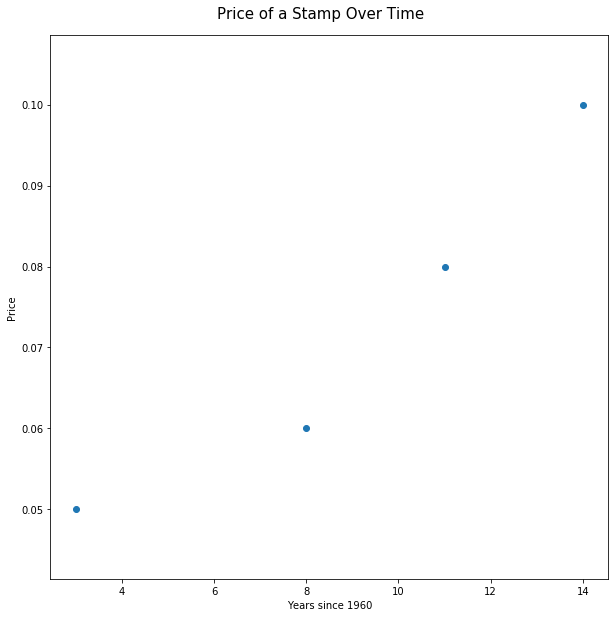

In [4]:
years = df['Date'][:4]
price = df['Price'][:4]
fig = plt.figure(figsize=(10,10))
plt.scatter(years, price)
plt.xlabel('Years since 1960')
plt.ylabel('Price')
fig.suptitle('Price of a Stamp Over Time', fontsize=15, y=0.92)

Now let's find the covariance and correlation of our two variables.

In [5]:
#Covariance
np.cov(years, price, bias=True)

array([[1.6500e+01, 7.5000e-02],
       [7.5000e-02, 3.6875e-04]])

In [6]:
#Covariance Divided by Variance = Correlation
np.cov(years, price, bias=True)[0][1] / (np.std(years) * np.std(price))

0.961508829696314

In [7]:
#Correlation & P-Value
stats.pearsonr(years, price)

(0.9615088296963138, 0.038491170303686206)

Now we can find the slope and intercept via least squares.

In [8]:
#Get Slope and Intercept
slope = np.cov(years, price, bias=True)[0][1] / np.var(years)
intercept = np.mean(price) - (slope * np.mean(years))

And our predicted values for the price of a stamp given our slope and intercept.

In [9]:
#Here are our predicted values based off of mx + b
(slope * years) + intercept

0    0.045227
1    0.067955
2    0.081591
3    0.095227
Name: Date, dtype: float64

In [10]:
predictions = (slope * years) + intercept

Now we can plot our predicted values relative to the observed values.

One thing to note - we can plot scatterplots of the raw data, but any line plots (regression or else) must be in order for them to be plotted properly. We can use 'argsort' to capture the sorting argument for the predictor variable, and then use that as the order we'll plot the predictor and dependent variable in.

Text(0.5, 0.92, 'Price of a Stamp Over Time')

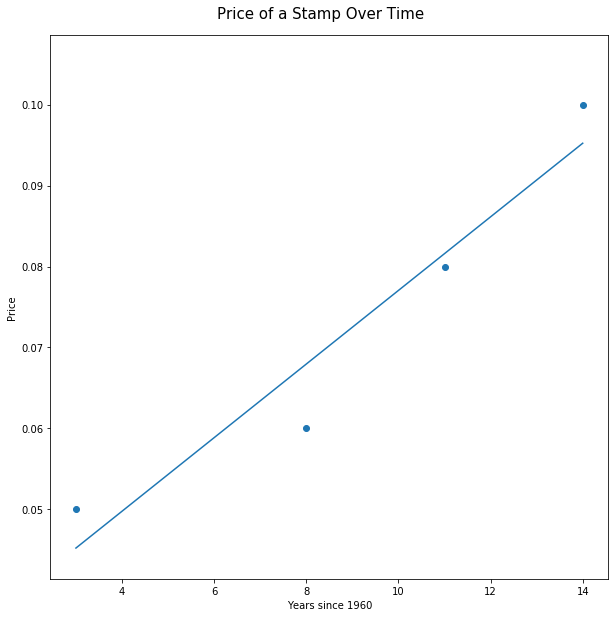

In [11]:
fig = plt.figure(figsize=(10,10))
plt.scatter(years, price)
sorted_order = np.argsort(years)
plt.plot(years[sorted_order], predictions[sorted_order])
plt.xlabel('Years since 1960')
plt.ylabel('Price')
fig.suptitle('Price of a Stamp Over Time', fontsize=15, y=0.92)

And we can find and calculate residuals.

In [12]:
#Below are the Residuals for Our Predictions
price - predictions

0    0.004773
1   -0.007955
2   -0.001591
3    0.004773
dtype: float64

In [13]:
residuals = price - predictions

There aren't many data points, but the residuals look randomly distributed around 0. Residuals are assumed to have a **normal distribution** with a mean of 0.

Text(0.5, 0.92, 'Residuals')

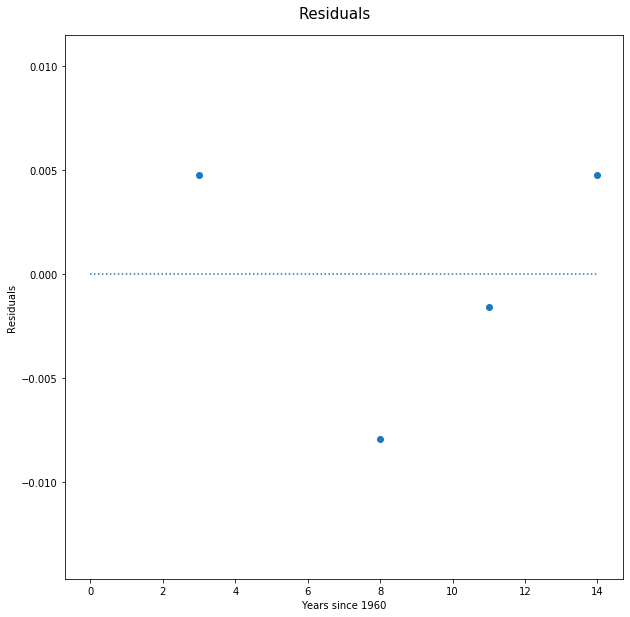

In [14]:
fig = plt.figure(figsize=(10,10))
plt.scatter(years, residuals)
plt.plot([0, years.max()], [0,0], linestyle='dotted')
plt.xlabel('Years since 1960')
plt.ylabel('Residuals')
fig.suptitle('Residuals', fontsize=15, y=0.92)

We can find the R-squared value of our least squares fit, either by finding 1 - the value of our residuals or simply squaring the correlation value.

In [15]:
#Manually Calculate R^2 Value
np.var(predictions) / np.var(price)

0.9244992295839759

In [16]:
#Same as
1 - (np.var(residuals) / np.var(price))

0.9244992295839752

In [17]:
#Also the Squared Value of the Correlation Coefficient
np.power(stats.pearsonr(years, price)[0], 2)

0.924499229583975

Let's make a **function** so that finding these values will be easier going forward.

In [18]:
def evaluate_linear_relationship(a, b):
    slope = np.cov(a, b, bias=True)[0][1] / np.var(a)
    intercept = np.mean(b) - (slope * np.mean(a))
    predictions = (slope * a) + intercept
    residuals = b - predictions
    return slope, intercept, predictions, residuals

Now we can repeat the above steps for the entire dataframe rather than the first four values.

In [19]:
slope, intercept, predictions, residuals = evaluate_linear_relationship(df['Date'], df['Price'])

This function is also available in our new utils package.

In [20]:
slope, intercept, predictions, residuals = utils.evaluate_linear_relationship(df['Date'], df['Price'])

Text(0.5, 0.92, 'Price of a Stamp Over Time')

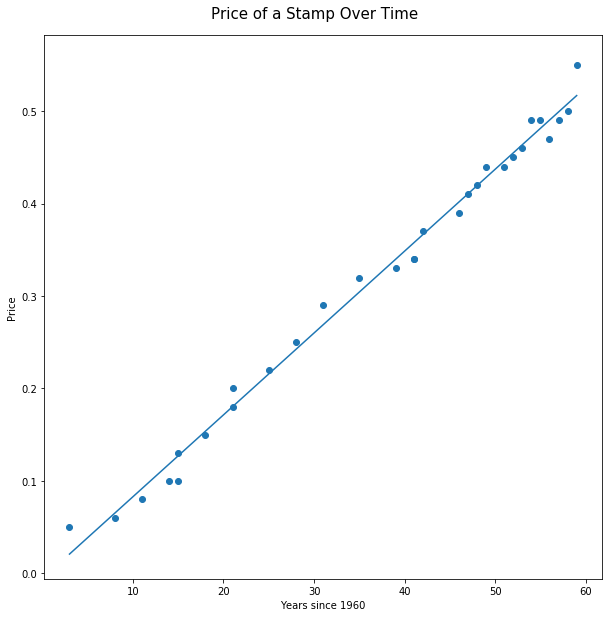

In [21]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df['Date'], df['Price'])
sorted_order = np.argsort(df['Date'])
plt.plot(df['Date'][sorted_order], predictions[sorted_order])
plt.xlabel('Years since 1960')
plt.ylabel('Price')
fig.suptitle('Price of a Stamp Over Time', fontsize=15, y=0.92)

Text(0.5, 0.92, 'Residuals')

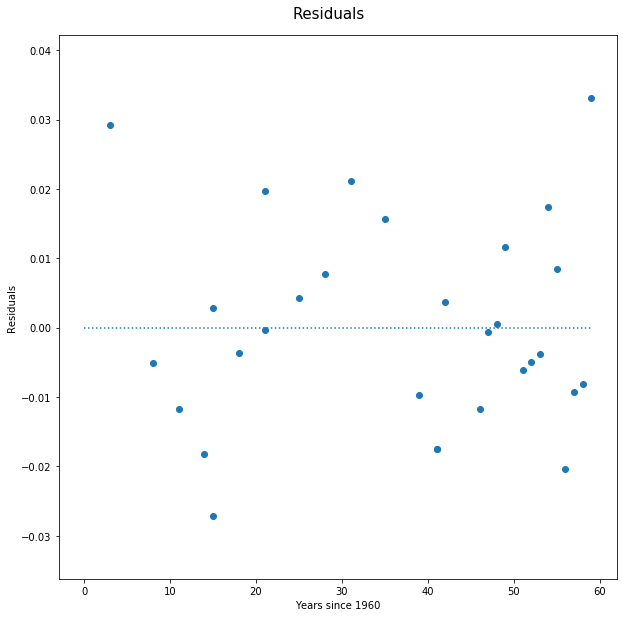

In [22]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df['Date'], residuals)
plt.plot([0, df['Date'][len(df) - 1]], [0,0], linestyle='dotted')
plt.xlabel('Years since 1960')
plt.ylabel('Residuals')
fig.suptitle('Residuals', fontsize=15, y=0.92)

In [23]:
#Manually Calculate R^2 Value
np.var(predictions) / np.var(df['Price'])

0.9908493178171104

The residuals look heteroskedastic and the R-squared value is 99%. Safe to say that there is a strong linear relationship between the two variables!

### Apple Stock Prices Example

In [24]:
#Read in Apple Dataset
prices = pd.read_csv('data/AAPL.csv')
prices['Date'] = pd.to_datetime(prices['Date'])
prices['Date'] = prices['Date'].dt.year
year_prices = prices.groupby('Date')['Close'].mean().reset_index()
year_prices = year_prices[year_prices['Date'] >= 1995].reset_index(drop=True)
year_prices['Date'] = year_prices['Date'] - 1995
year_prices.head()

,Date,Close
0,0,1.407552
1,1,0.856027
2,2,0.618583
3,3,1.089472
4,4,2.123140


Text(0, 0.5, 'Average Annual Stock Price')

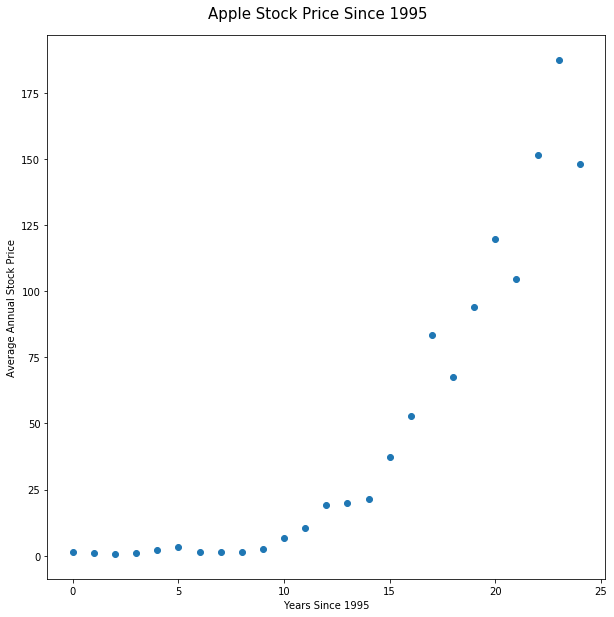

In [25]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], year_prices['Close'])
fig.suptitle('Apple Stock Price Since 1995', fontsize=15, y=0.92)
plt.xlabel('Years Since 1995')
plt.ylabel('Average Annual Stock Price')

Above we see that the relationship between years and Apple stock price is non-linear.

In [26]:
slope_apple, intercept_apple, predictions_apple, residuals_apple = utils.evaluate_linear_relationship(year_prices['Date'], year_prices['Close'])

Text(0, 0.5, 'Average Annual Stock Price')

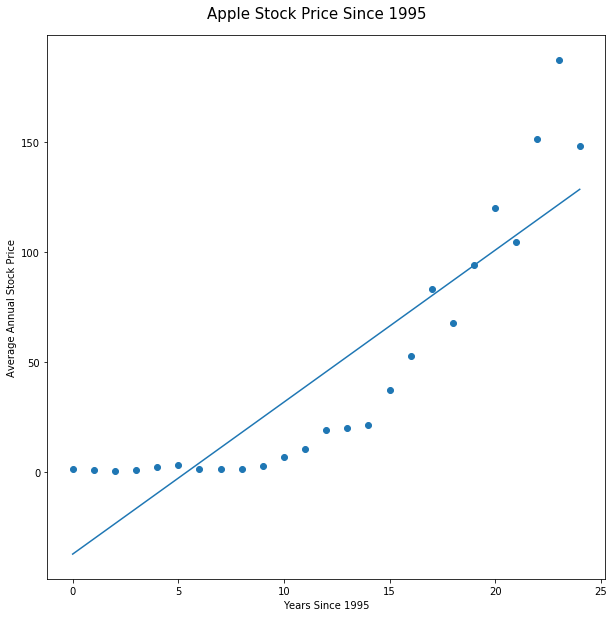

In [27]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], year_prices['Close'])
sorted_order = np.argsort(year_prices['Date'])
plt.plot(year_prices['Date'][sorted_order], predictions_apple[sorted_order])
fig.suptitle('Apple Stock Price Since 1995', fontsize=15, y=0.92)
plt.xlabel('Years Since 1995')
plt.ylabel('Average Annual Stock Price')

Text(0.5, 0.92, 'Residuals')

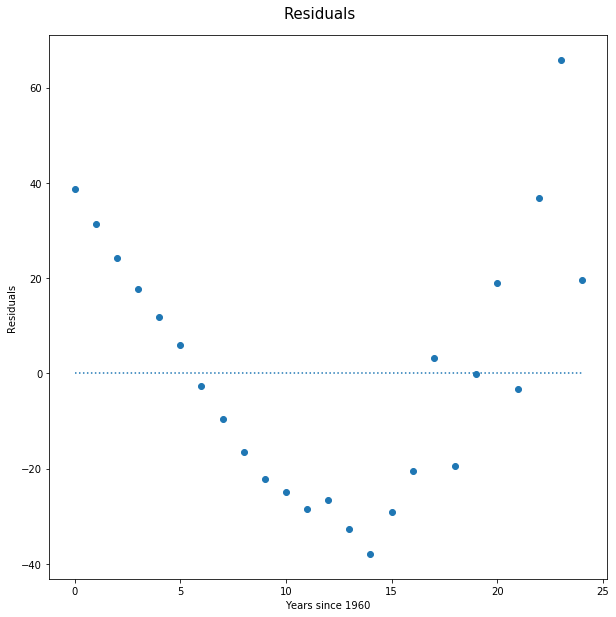

In [28]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], residuals_apple)
plt.plot([0, year_prices['Date'][len(year_prices) - 1]], [0,0], linestyle='dotted')
plt.xlabel('Years since 1960')
plt.ylabel('Residuals')
fig.suptitle('Residuals', fontsize=15, y=0.92)

The residuals graph is also pretty clearly non-random...

In [29]:
np.var(predictions_apple) / np.var(year_prices['Close'])

0.7834810949563028

Even though the data has an R^2 value of over 78%

Text(0, 0.5, 'Average Annual Stock Price')

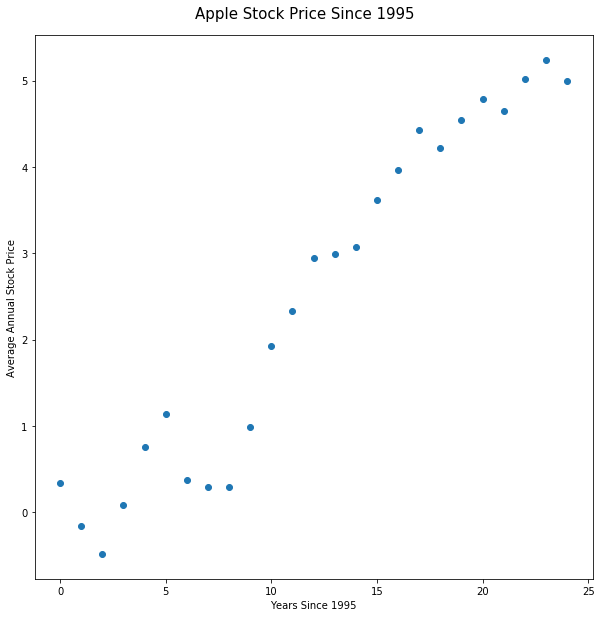

In [30]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], np.log(year_prices['Close']))
fig.suptitle('Apple Stock Price Since 1995', fontsize=15, y=0.92)
plt.xlabel('Years Since 1995')
plt.ylabel('Average Annual Stock Price')

In [31]:
slope_apple, intercept_apple, predictions_apple, residuals_apple = evaluate_linear_relationship(year_prices['Date'], np.log(year_prices['Close']))

Text(0, 0.5, 'Average Annual Stock Price')

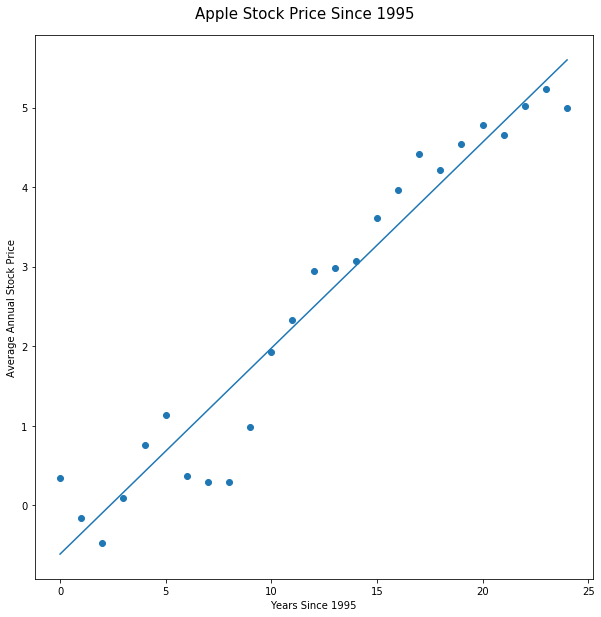

In [32]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], np.log(year_prices['Close']))
sorted_order = np.argsort(year_prices['Date'])
plt.plot(year_prices['Date'][sorted_order], predictions_apple[sorted_order])
fig.suptitle('Apple Stock Price Since 1995', fontsize=15, y=0.92)
plt.xlabel('Years Since 1995')
plt.ylabel('Average Annual Stock Price')

Text(0.5, 0.92, 'Residuals')

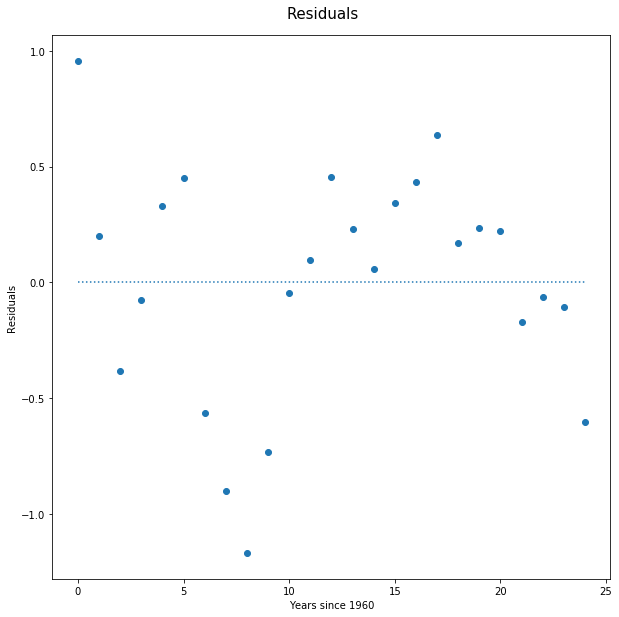

In [33]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Date'], residuals_apple)
plt.plot([0, year_prices['Date'][len(year_prices) - 1]], [0,0], linestyle='dotted')
plt.xlabel('Years since 1960')
plt.ylabel('Residuals')
fig.suptitle('Residuals', fontsize=15, y=0.92)

In [34]:
np.var(predictions_apple) / np.var(np.log(year_prices['Close']))

0.935736944719299

The residuals look heteroskedastic and the R-squared value is 93%. Again we can observe there is a strong linear relationship between the two variables.